In [90]:
# Intended to be run via a virtual environment with the packages
# in graphinference/requirements.txt installed.

import random

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate

import statsmodels
from statsmodels.tsa.api import VAR

import graphinference.statsmodels_var_helpers as var_helpers

# Seeds and rng for reproducibility
random.seed(111)
np.random.seed(111)
rng = np.random.RandomState(111)

# Exploring Connections Between Vector Autoregression and Differential Equations

## Simulate an ODE

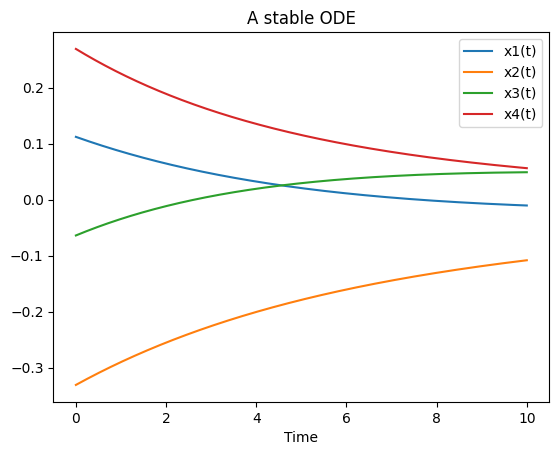

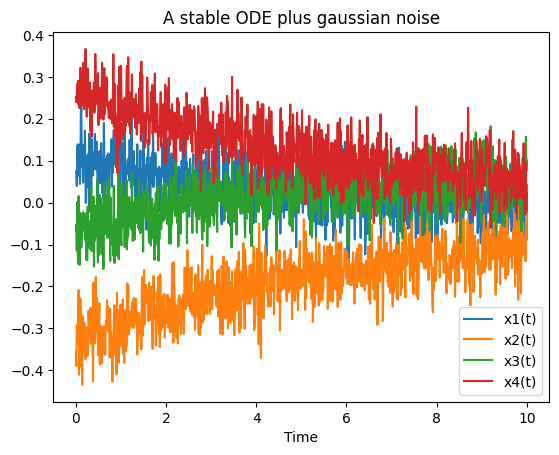

In [80]:


# Build adj matrix
A = np.array([
    [0., 1., 0., 1.],
    [1., 0., 0., 0.],
    [0., 0., 0., 1.],
    [1., 0., 1. , 0.],
])

D = np.diag(np.sum(A.T, axis=1))
c = -0.1

# Use the adj to make a linear ODE
dxdt = lambda x, t : c * (D - A) @ x
x0 = np.random.rand(A.shape[0]) -.5

num_points = 1000
t = np.linspace(0, 10, num_points)
x_sol = integrate.odeint(dxdt, x0, t)

# Plot the result
for i in range(A.shape[0]):
    plt.plot(t, x_sol[:, i], label=f"x{i+1}(t)")
plt.legend()
plt.title("A stable ODE")
plt.xlabel("Time")
plt.show()

# Add noise ~ N(0, sig)
sig = 0.05
gaus_noise = sig * np.random.randn(*x_sol.shape)
noisy_x_sol = x_sol + gaus_noise

# Plot with noise
for i in range(A.shape[0]):
    plt.plot(t, noisy_x_sol[:, i], label=f"x{i+1}(t)")
plt.legend()
plt.title("A stable ODE plus gaussian noise")
plt.xlabel("Time")
plt.show()

Dickey-Fuller pvalue. Probability timeseries 1 is not stationary: 0.0
Dickey-Fuller pvalue. Probability timeseries 2 is not stationary: 0.0
Dickey-Fuller pvalue. Probability timeseries 3 is not stationary: 0.0
Dickey-Fuller pvalue. Probability timeseries 4 is not stationary: 0.0


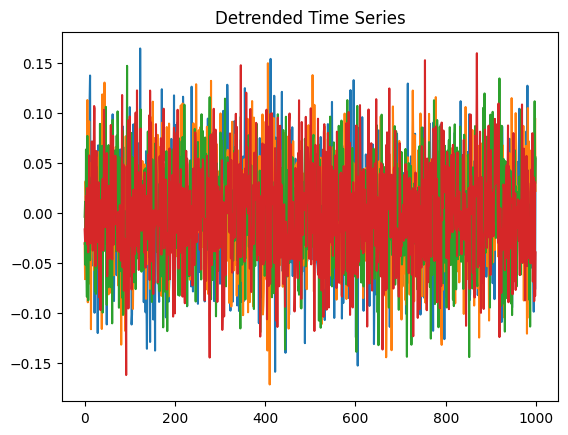

In [81]:
# VAR Analysis of Synthetic Data

# Detrend
detrend_noisy_x_sol = statsmodels.tsa.tsatools.detrend(noisy_x_sol, axis=0, order=2)
plt.plot(detrend_noisy_x_sol)
plt.title("Detrended Time Series")

# Check for stationarity
for i in range(A.shape[0]):
    adf_result = statsmodels.tsa.stattools.adfuller(detrend_noisy_x_sol[:, i])
    adf, pval, used_lag, nobs, critical_vals, icbest = adf_result
    print(f"Dickey-Fuller pvalue. Probability timeseries {i+1} is not stationary: {pval}")

In [82]:
var1_model = VAR(detrend_noisy_x_sol)
var1_fit = var1_model.fit(maxlags=2, verbose=True)
print(var1_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, Jan, 2023
Time:                     16:13:40
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -23.7955
Nobs:                     998.000    HQIC:                  -23.9052
Log likelihood:           6333.86    FPE:                3.88050e-11
AIC:                     -23.9725    Det(Omega_mle):     3.74362e-11
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.000061         0.001606            0.038           0.970
L1.y1         0.018180         0.031879            0.570           0.568
L1.y2        -0.012721         0.032709           -0.389           0.697
L1.y3         0.022728

In [83]:

coef, pvals = var_helpers.coef_matrix(var1_fit, timestep_lag=2, return_pvals=True)
print("Lag 1 Coefficients:")
print(np.round(coef, decimals=2))

print("Corresponding P-Values")
print(np.round(pvals, decimals=4))

Lag 1 Coefficients:
[[-0.05 -0.02  0.01 -0.02]
 [ 0.    0.04  0.01 -0.02]
 [-0.02 -0.01 -0.03 -0.01]
 [ 0.   -0.03  0.01  0.04]]
Corresponding P-Values
[[0.1    0.6133 0.7019 0.4672]
 [0.9505 0.2421 0.688  0.599 ]
 [0.5584 0.8677 0.3931 0.797 ]
 [0.8931 0.2689 0.646  0.2264]]


## Repeat the Above Across Parameter Ranges

### Helper Function

In [84]:
def vectorized_adf(X):
    """Apply dicky fuller to each column of a 2D array `X`.
    
    Returns pvalues for each column.
    """
    pvals = np.ones(X.shape[1])
    for i in range(X.shape[1]):
        adf_result = statsmodels.tsa.stattools.adfuller(X[:, i])
        pvals[i] = adf_result[1]
    return pvals

### Run Repeated Experiment

In [85]:
trials_per_param_set = 100
stds_of_noise = [0, 0.01, 0.05, 0.1]
num_points = 1000
t = np.linspace(0, 10, num_points)
trend_orders = [1, 2]

results = {}

for sig in stds_of_noise:
    for order in trend_orders:
        pvals = {"adf":[], "var":[]}
        for i in range(trials_per_param_set):
            x0 = np.random.rand(A.shape[0]) - .5
            x_sol = integrate.odeint(dxdt, x0, t)
            gaus_noise = sig * np.random.randn(*x_sol.shape)
            noisy_x_sol = x_sol + gaus_noise
            detrend_x_sol = statsmodels.tsa.tsatools.detrend(noisy_x_sol, axis=0, order=order)
            
            # Augmented Dicky Fuller Test for stationarity
            adf_pvals = vectorized_adf(detrend_x_sol)

            # Fit VAR(1)
            try:
                var_fit = VAR(detrend_x_sol).fit(maxlags=1)
                _, var1_pvals = var_helpers.coef_matrix(var_fit, timestep_lag=1, return_pvals=True)
            except:
                # If the fit fail, then make all pvalues nans
                var1_pvals = np.ones((len(x0), len(x0)))
                var1_pvals[:, :] = np.nan
            
            # Store dickey fuller and VAR coeff p-values
            pvals["adf"].append(adf_pvals)
            pvals["var"].append(var1_pvals)
        results[(sig, order)] = pvals

        
        
        
        


/Users/djpassey/Code/graphinference/graphinf_venv/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/var_model.py:1545: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))
/Users/djpassey/Code/graphinference/graphinf_venv/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/var_model.py:1545: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))
/Users/djpassey/Code/graphinference/graphinf_venv/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/var_model.py:1545: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))
/Users/djpassey/Code/graphinference/graphinf_venv/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/var_model.py:1545: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))
/Users/djpassey/Code/graphinference/graphinf_venv/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/var_model.py:154

### Stationary test for different amounts of noise and detrending

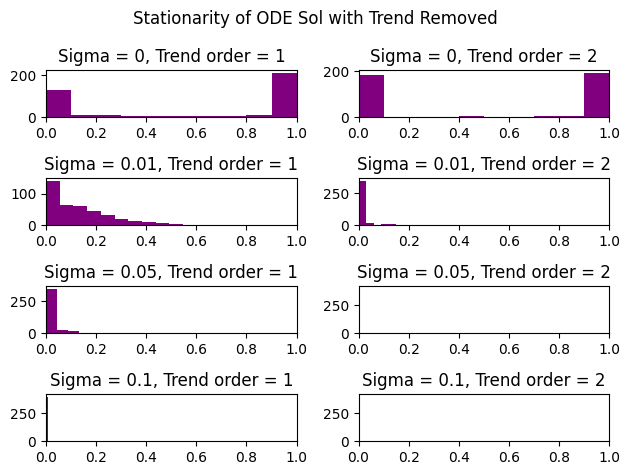

In [86]:
fig, ax = plt.subplots(4, 2)

for i, sig in enumerate(stds_of_noise):
    for j, order in enumerate(trend_orders):
        all_adf_pvals = np.hstack(results[(sig, order)]["adf"])
        ax[i, j].set_xlim(0, 1)

        ax[i, j].hist(all_adf_pvals, color="purple")
        ax[i, j].set_title(f"Sigma = {sig}, Trend order = {order}")

fig.suptitle("Stationarity of ODE Sol with Trend Removed")
fig.tight_layout()


### VAR(1) p-values for different levels of noise and detrending

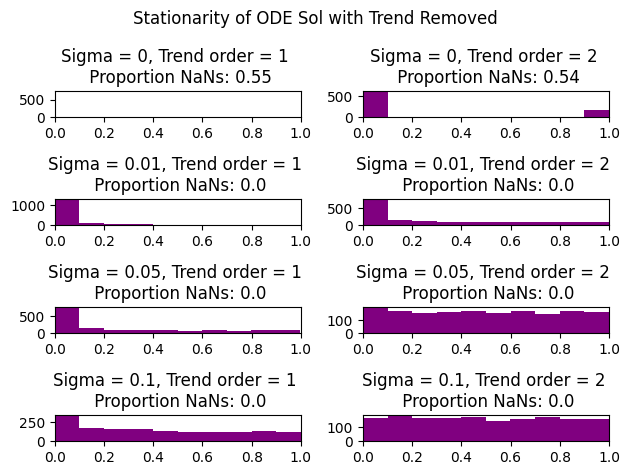

In [87]:
fig, ax = plt.subplots(4, 2)

for i, sig in enumerate(stds_of_noise):
    for j, order in enumerate(trend_orders):
        all_var_pvals = np.hstack(results[(sig, order)]["var"])
        all_var_pvals = np.ravel(all_var_pvals)

        nan_mask = np.isnan(all_var_pvals)
        num_nans = np.sum(nan_mask)

        ax[i, j].set_xlim(0, 1)

        ax[i, j].hist(all_var_pvals[~nan_mask], color="purple")
        ax[i, j].set_title(f"Sigma = {sig}, Trend order = {order} \n Proportion NaNs: {num_nans/len(nan_mask)}")

fig.suptitle("Stationarity of ODE Sol with Trend Removed")
fig.tight_layout()


### Proportion of values found to be significant

In [88]:
signif_cutoff = 0.05

adf_pval_proportion = np.zeros((4, 2))
var_coef_pval_proportion = np.zeros((4, 2))

for i, sig in enumerate(stds_of_noise):
    for j, order in enumerate(trend_orders):
        # Dickey Fuller p-value proportion significant
        all_adf_pvals = np.hstack(results[(sig, order)]["adf"])
        adf_pval_proportion[i, j] = np.mean(all_adf_pvals < signif_cutoff)

        # VAR coeff p-values
        all_var_pvals = np.hstack(results[(sig, order)]["var"])
        all_var_pvals = np.ravel(all_var_pvals)
        
        ## Replace Nans with ones
        nan_mask = np.isnan(all_var_pvals)
        all_var_pvals[nan_mask] = 1.0

        ## Compute proportion significant
        var_coef_pval_proportion[i, j] = np.mean(all_var_pvals < signif_cutoff)


In [97]:
rownames = [f"Sigma={sig}" for sig in stds_of_noise]
colnames = ["Linear Detrend", "Quadratic Detrend"]
var_pval_df = pd.DataFrame(var_coef_pval_proportion, index=rownames, columns=colnames)
adf_pval_df = pd.DataFrame(adf_pval_proportion, index=rownames, columns=colnames)

adf_pval_df = adf_pval_df.style.set_caption('Proportion of non stationary time series by noise and detrending method')
var_pval_df = var_pval_df.style.set_caption('Proportion of signifiant VAR coeffs by noise and detrending method')

adf_pval_df

,Linear Detrend,Quadratic Detrend
Sigma=0,0.307500,0.440000
Sigma=0.01,0.342500,0.897500
Sigma=0.05,0.880000,1.000000
Sigma=0.1,0.997500,1.000000


In [98]:
var_pval_df

,Linear Detrend,Quadratic Detrend
Sigma=0,0.000000,0.360000
Sigma=0.01,0.713125,0.376250
Sigma=0.05,0.392500,0.063125
Sigma=0.1,0.145625,0.050000


## VAR Analytic Solution to the ODE

We will linearize the ODE in order to arrive at a vector autoregressive
formulation of the same system.

$$ \frac{d\mathbf{x}}{dt} = c(D - A)\mathbf{x}(t)$$

$$\frac{\mathbf{x}_t - \mathbf{x}_{t-1}}{h} = c(D - A) \mathbf{x}_{t-1}$$

$$ \mathbf{x}_t = hc(D - A)\mathbf{x}_{t-1} + \mathbf{x}_{t-1} $$

$$ \mathbf{x}_t = [hc(D - A) + I] \mathbf{x}_{t-1} $$

Therefore, if we assume a VAR(1) model, then $A_1 = hc(D - A) + I$ should
approximate the system when $h$ is small.

We will verify this in code below:



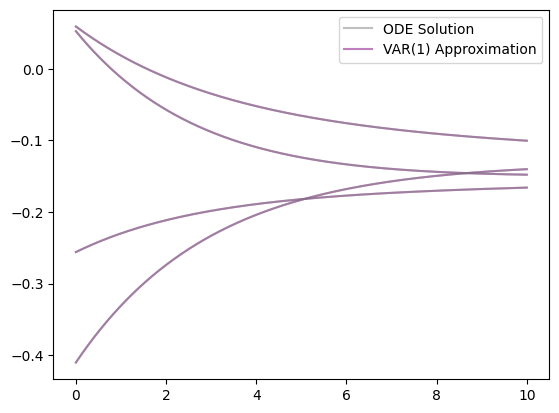

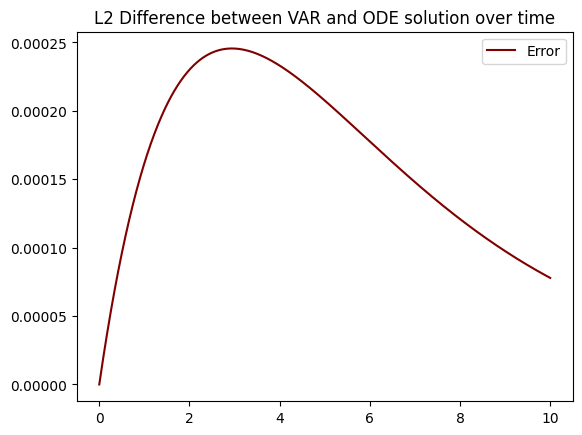

In [99]:
h = t[1] - t[0]
A1 = h * c * (D - A) + np.eye(A.shape[0])

var_approx_ode_sol = np.zeros((num_points, A.shape[0]))
x = x0
for i in range(num_points):
    var_approx_ode_sol[i, :] = x
    x = A1 @ x

error = np.sum((x_sol - var_approx_ode_sol)**2, axis=1) ** .5
plt.plot(t, var_approx_ode_sol, color="purple", alpha=.5)
plt.plot(t, x_sol, color="gray", alpha=.5)
plt.plot(t[0], x_sol[0, 0], color="gray", alpha=.5, label="ODE Solution")
plt.plot(t[0], var_approx_ode_sol[0, 0], color="purple", alpha=.5, label="VAR(1) Approximation")
plt.legend()
plt.show()

plt.plot(t, error, color="maroon", label="Error")
plt.title("L2 Difference between VAR and ODE solution over time")
plt.legend()
plt.show()

In [100]:
print(list(var1_model.__dict__.keys()))

args_names = var1_fit._results.simulate_var.__code__.co_varnames[:var1_fit._results.simulate_var.__code__.co_argcount]
print(args_names)

['data', 'k_constant', 'exog', 'endog', '_data_attr', '_init_keys', '_index', '_index_generated', '_index_none', '_index_int64', '_index_dates', '_index_freq', '_index_inferred_freq', 'neqs', 'n_totobs', 'nobs', 'k_trend']
('self', 'steps', 'offset', 'seed')
